# Advanced Machine Learning using Spark MLlib

## Introduction to Spark MLlib
Spark MLlib is a scalable library for machine learning that integrates seamlessly with the Spark ecosystem. It supports a wide range of tasks, including regression, classification, clustering, and collaborative filtering.

### Linear Regression with Spark MLlib

In [ ]:
from pyspark.sql import SparkSession
from pyspark.ml.regression import LinearRegression
from pyspark.ml.feature import VectorAssembler

# Initialize Spark Session
spark = SparkSession.builder.appName('MLlib Example').getOrCreate()

# Load sample data
data = [(1, 5.0, 20.0), (2, 10.0, 25.0), (3, 15.0, 30.0), (4, 20.0, 35.0)]
columns = ['ID', 'Feature', 'Target']
df = spark.createDataFrame(data, columns)

# Prepare data for modeling
assembler = VectorAssembler(inputCols=['Feature'], outputCol='Features')
df_transformed = assembler.transform(df)

# Train a linear regression model
lr = LinearRegression(featuresCol='Features', labelCol='Target')
model = lr.fit(df_transformed)

# Print model coefficients
print(f'Coefficients: {model.coefficients}')
print(f'Intercept: {model.intercept}')


Coefficients: [0.9999999999999992]
Intercept: 15.000000000000009


### Logistic Regression

In [ ]:
from pyspark.sql import SparkSession
from pyspark.ml.classification import LogisticRegression
from pyspark.ml.linalg import Vectors

# Initialize Spark Session
spark = SparkSession.builder.appName("LogisticRegressionExample").getOrCreate()

# Load sample data
data = [
    (1, Vectors.dense([2.0, 3.0]), 0),
    (2, Vectors.dense([1.0, 5.0]), 1),
    (3, Vectors.dense([2.5, 4.5]), 1),
    (4, Vectors.dense([3.0, 6.0]), 0)
]
columns = ['ID', 'Features', 'Label']
df = spark.createDataFrame(data, columns)

# Train logistic regression model
lr = LogisticRegression(featuresCol='Features', labelCol='Label')
model = lr.fit(df)

# Display coefficients and summary
print(f'Coefficients: {model.coefficients}')
print(f'Intercept: {model.intercept}')

Coefficients: [-12.262057929180484,4.087352266486688]
Intercept: 11.56891272665312


### KMeans Clustering

In [ ]:
from pyspark.sql import SparkSession
from pyspark.ml.clustering import KMeans
from pyspark.ml.linalg import Vectors

# Initialize Spark Session
spark = SparkSession.builder.appName("KMeansClusteringExample").getOrCreate()

# Load sample data
data = [
    (1, Vectors.dense([1.0, 1.0])),
    (2, Vectors.dense([5.0, 5.0])),
    (3, Vectors.dense([10.0, 10.0])),
    (4, Vectors.dense([15.0, 15.0]))
]
columns = ['ID', 'Features']
df = spark.createDataFrame(data, columns)

# Train KMeans clustering model
kmeans = KMeans(featuresCol='Features', k=2, seed=42)  # k=2 untuk 2 cluster
model = kmeans.fit(df)

# Show cluster centers
centers = model.clusterCenters()
print(f'Cluster Centers: {centers}')


Cluster Centers: [array([12.5, 12.5]), array([3., 3.])]


## Homework
- Load a real-world dataset into Spark and prepare it for machine learning tasks.
- Build a classification model using Spark MLlib and evaluate its performance.
- Explore hyperparameter tuning using cross-validation.


Struktur Dataset:
root
 |-- age: integer (nullable = true)
 |-- job: string (nullable = true)
 |-- marital: string (nullable = true)
 |-- education: string (nullable = true)
 |-- default: string (nullable = true)
 |-- balance: integer (nullable = true)
 |-- housing: string (nullable = true)
 |-- loan: string (nullable = true)
 |-- contact: string (nullable = true)
 |-- day: integer (nullable = true)
 |-- month: string (nullable = true)
 |-- duration: integer (nullable = true)
 |-- campaign: integer (nullable = true)
 |-- pdays: integer (nullable = true)
 |-- previous: integer (nullable = true)
 |-- poutcome: string (nullable = true)
 |-- deposit: string (nullable = true)


Ringkasan Statistik:
+-------+------------------+-------+--------+---------+-------+------------------+-------+-----+--------+------------------+-----+------------------+------------------+------------------+------------------+--------+-------+
|summary|               age|    job| marital|education|default|          

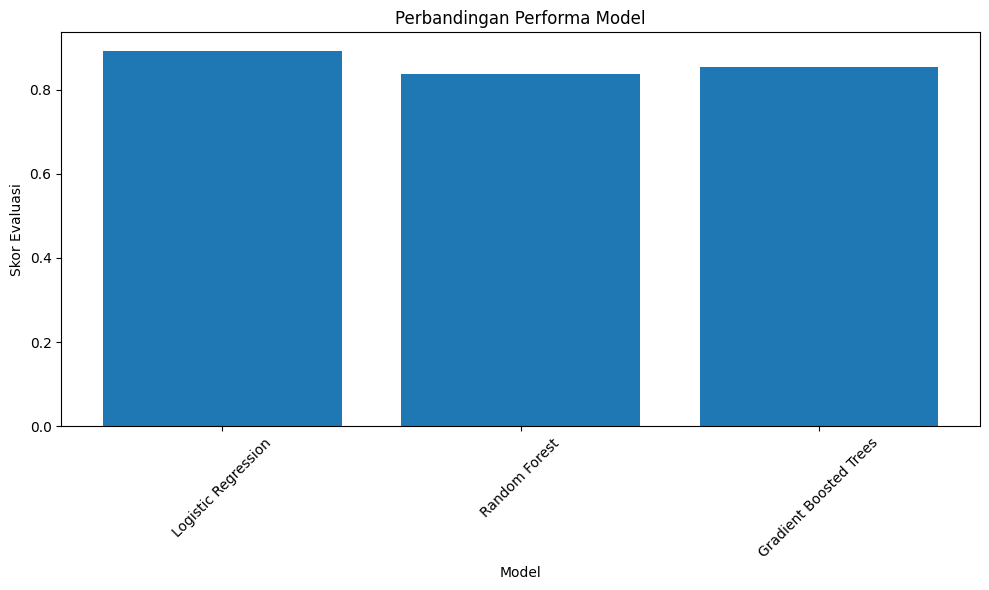

In [21]:
from pyspark.sql import SparkSession
from pyspark.sql.functions import col, when
from pyspark.ml.feature import StringIndexer, OneHotEncoder, VectorAssembler, StandardScaler
from pyspark.ml import Pipeline
from pyspark.ml.classification import LogisticRegression, RandomForestClassifier, GBTClassifier
from pyspark.ml.evaluation import BinaryClassificationEvaluator, MulticlassClassificationEvaluator
from pyspark.ml.tuning import ParamGridBuilder, CrossValidator
from pyspark.ml.regression import GeneralizedLinearRegression
import matplotlib.pyplot as plt

# Inisialisasi SparkSession dengan konfigurasi tambahan
spark = SparkSession.builder \
    .appName("Advanced Bank Marketing ML Analysis") \
    .config("spark.executor.memory", "4g") \
    .config("spark.driver.memory", "4g") \
    .getOrCreate()

# Load dataset
file_path = "bank.csv"
df = spark.read.csv(file_path, header=True, inferSchema=True)

# 1. Analisis Eksplorasi Data
print("Struktur Dataset:")
df.printSchema()

print("\nRingkasan Statistik:")
df.describe().show()

# Mengecek distribusi label
label_distribution = df.groupBy("deposit").count()
print("\nDistribusi Label:")
label_distribution.show()

# 2. Persiapan Dataset
# Transformasi label menjadi numerik
df = df.withColumn("label", when(col("deposit") == "yes", 1.0).otherwise(0.0))
df = df.drop("deposit")

# Identifikasi fitur
categorical_cols = ["job", "marital", "education", "default", "housing", "loan", "contact", "month", "poutcome"]
numeric_cols = ["age", "balance", "day", "duration", "campaign", "pdays", "previous"]

# 3. Preprocessing dengan Pipeline
# StringIndexer untuk fitur kategorikal
indexers = [StringIndexer(inputCol=col, outputCol=f"{col}_index", handleInvalid="keep")
            for col in categorical_cols]

# OneHotEncoder untuk fitur kategorikal
encoders = [OneHotEncoder(inputCols=[f"{col}_index" for col in categorical_cols],
                          outputCols=[f"{col}_encoded" for col in categorical_cols])]

# StandardScaler untuk fitur numerik
scaler = StandardScaler(inputCol="numeric_features",
                        outputCol="scaled_numeric_features",
                        withStd=True,
                        withMean=True)

# Persiapan fitur numerik
assembler_numeric = VectorAssembler(inputCols=numeric_cols, outputCol="numeric_features")

# VectorAssembler untuk menggabungkan semua fitur
final_assembler = VectorAssembler(
    inputCols=[f"{col}_encoded" for col in categorical_cols] + ["scaled_numeric_features"],
    outputCol="features"
)

# 4. Model-model Machine Learning
# Logistic Regression
lr = LogisticRegression(featuresCol="features", labelCol="label")

# Random Forest
rf = RandomForestClassifier(featuresCol="features", labelCol="label")

# Gradient Boosted Trees
gbt = GBTClassifier(featuresCol="features", labelCol="label")

# 5. Pipeline Preprocessing dan Model
# Konstruksi pipeline untuk setiap model
def create_pipeline(model):
    return Pipeline(stages=indexers + encoders + [
        assembler_numeric,
        scaler,
        final_assembler,
        model
    ])

# 6. Hyperparameter Tuning dengan Cross-Validation
# Parameter Grid untuk setiap model
param_grid_lr = ParamGridBuilder() \
    .addGrid(lr.regParam, [0.01, 0.1, 1.0]) \
    .addGrid(lr.elasticNetParam, [0.0, 0.5, 1.0]) \
    .build()

param_grid_rf = ParamGridBuilder() \
    .addGrid(rf.numTrees, [10, 50, 100]) \
    .addGrid(rf.maxDepth, [5, 10, 15]) \
    .build()

param_grid_gbt = ParamGridBuilder() \
    .addGrid(gbt.maxIter, [50, 100]) \
    .addGrid(gbt.maxDepth, [5, 10]) \
    .build()

# Evaluator
binary_evaluator = BinaryClassificationEvaluator(labelCol="label")
multiclass_evaluator = MulticlassClassificationEvaluator(labelCol="label")

# Fungsi untuk melakukan cross-validation
def perform_cross_validation(pipeline, param_grid, evaluator):
    crossval = CrossValidator(
        estimator=pipeline,
        estimatorParamMaps=param_grid,
        evaluator=evaluator,
        numFolds=5
    )
    return crossval

# 7. Split Dataset menjadi data pelatihan dan pengujian
(train_data, test_data) = df.randomSplit([0.8, 0.2], seed=42)

# Daftar model untuk eksperimen
models_to_evaluate = [
    ("Logistic Regression", lr, create_pipeline(lr), param_grid_lr, binary_evaluator),
    ("Random Forest", rf, create_pipeline(rf), param_grid_rf, multiclass_evaluator),
    ("Gradient Boosted Trees", gbt, create_pipeline(gbt), param_grid_gbt, multiclass_evaluator)
]

# 8. Evaluasi Model
results = []
for name, model, pipeline, params, evaluator in models_to_evaluate:
    print(f"\n--- Evaluasi {name} ---")

    # Cross-validation
    cv_model = perform_cross_validation(pipeline, params, evaluator)
    cv_fitted_model = cv_model.fit(train_data)

    # Prediksi pada data test
    predictions = cv_fitted_model.transform(test_data)

    # Evaluasi performa
    score = evaluator.evaluate(predictions)
    results.append({
        "Model": name,
        "Score": score
    })

    print(f"Performance Score: {score}")

    # Tampilkan beberapa prediksi
    predictions.select("features", "label", "prediction", "probability").show(5)

# 9. Visualisasi Perbandingan Model
plt.figure(figsize=(10, 6))
plt.bar([r["Model"] for r in results], [r["Score"] for r in results])
plt.title("Perbandingan Performa Model")
plt.xlabel("Model")
plt.ylabel("Skor Evaluasi")
plt.xticks(rotation=45)
plt.tight_layout()
plt.savefig("model_comparison.png")

# Simpan hasil eksperimen
spark.createDataFrame(results).write.csv("model_results", mode="overwrite", header=True)

# Tutup SparkSession
spark.stop()

print("\nAnalisis selesai.")